# Test of bespoke neural network

Import necessary modules:

In [1]:
from classes.MyModel import MyModel
import torch
import torch.nn as nn
import math as math
from pathlib import Path
import numpy as np
from torchviz import make_dot

from modules.helper_functions_tsp import (find_problem_size,
load_dict_from_json, read_file_name, validate_distance_array,
cost_fn_fact, cost_fn_tensor, hot_start, hot_start_list_to_string)

from modules.config import NETWORK_DIR, DATA_SOURCES, GRAPH_DIR
from modules.helper_ML_functions import find_device

Set up constants:

In [ ]:
LOCATIONS = 6
DECODING_FORMULATION = 'original'
GRAY = False
STD_DEV = 0.05
NUM_EPOCHS = 150
LR = 0.0002
VERBOSE = False
BATCH_SIZE = 32
MOMENTUM = 0.0
WEIGHT_DECAY = 0.0005

Read in data and report on data read:

In [3]:
sources_filename = Path(NETWORK_DIR).joinpath(DATA_SOURCES)
data_source_dict = load_dict_from_json(sources_filename)
filename = read_file_name(str(LOCATIONS), data_source_dict)
filepath = Path(NETWORK_DIR).joinpath(filename)
best_dist = data_source_dict[str(LOCATIONS)]['best']
print(f'Data will be read from filename {filepath}.  It is known that the shortest distance is {best_dist}.')

Reading distance data
Data will be read from filename networks\sim_dist_6_locs.txt.  It is known that the shortest distance is 241.0.


Read in and validate distance array:

In [4]:
distance_array = np.genfromtxt(filepath)
validate_distance_array(distance_array, LOCATIONS)

Evaluate cost function and clear cache:

In [5]:
cost_fn = cost_fn_fact(LOCATIONS, distance_array, GRAY, method = DECODING_FORMULATION, verbose=VERBOSE)
cost_fn.clear_cache()

Check if CUDA is available and set the device

In [6]:
device = find_device()
print(f"Using device: {device}")

Using device: cuda


Find problem size:

In [7]:
qubits = find_problem_size(LOCATIONS, DECODING_FORMULATION)
print(f'There are {qubits} qubits needed for {LOCATIONS} locations in the {DECODING_FORMULATION} formulation.')

There are 8 qubits needed for 6 locations in the original formulation.


Find a hot start using a lazy classical algorithm and find the quality of the hot start:

In [8]:
hot_start_list = hot_start(distance_array, LOCATIONS)
print(f'The hot start location list is {hot_start_list}')
bin_hot_start_list =  hot_start_list_to_string(hot_start_list, LOCATIONS, GRAY, DECODING_FORMULATION)
print(f'This is equivalent to a binary list: {bin_hot_start_list}')
bin_hot_start_list_tensor = torch.tensor([bin_hot_start_list])
print(f'bin_hot_start_list_tensor = {bin_hot_start_list_tensor}')
distance_tensor = cost_fn_tensor(bin_hot_start_list_tensor, cost_fn).clone().detach().requires_grad_(True)
print(f'The hot start distance is {float(distance_tensor):.1f}, compared to a best distance of {best_dist:.1f}.')

The hot start location list is [0, 3, 5, 4, 1, 2]
This is equivalent to a binary list: [0, 1, 0, 1, 1, 1, 0, 0]
bin_hot_start_list_tensor = tensor([[0, 1, 0, 1, 1, 1, 0, 0]])
The hot start distance is 279.6, compared to a best distance of 241.0.


Set up input as repeated hot start tensor calculated above:

In [9]:
unrepeated_input = bin_hot_start_list_tensor.float().to(device)
my_input = unrepeated_input.repeat(BATCH_SIZE, 1).requires_grad_(True)

Set up model with gradient required:

In [10]:

model = MyModel(qubits, 2, STD_DEV, cost_fn).to(device)
for param in model.parameters():
    param.requires_grad = True

Report on model parameters:

In [11]:
total_params = sum(
	param.numel() for param in model.parameters()
)
trainable_params = sum(
	p.numel() for p in model.parameters() if p.requires_grad
)

print(f'There are {total_params} parameters in total, of which {trainable_params} are trainable')

for name, param in model.named_parameters():
    print(f"Parameter {name} requires_grad: {param.requires_grad}")

There are 144 parameters in total, of which 144 are trainable
Parameter fc1.weight requires_grad: True
Parameter fc1.bias requires_grad: True
Parameter fc2.weight requires_grad: True
Parameter fc2.bias requires_grad: True


Test the Sine activation function and print out a graph:

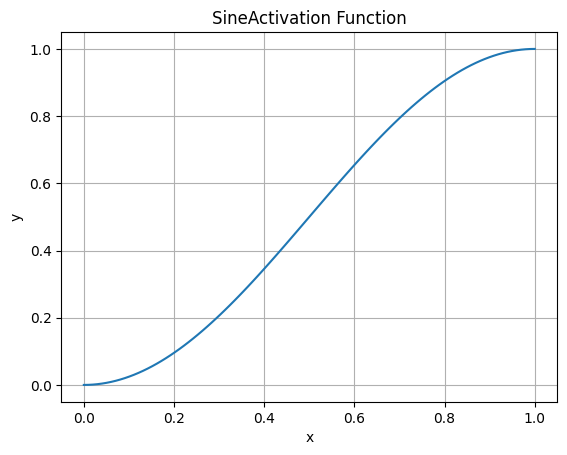

In [12]:
from classes.MyModel import MySine
import matplotlib.pyplot as plt
title = 'SineActivation Function'
filepath = Path(GRAPH_DIR).joinpath(title + '.png')

# create custom dataset
x = torch.linspace(0, 1, 100)
k = MySine()
y = k(x)

# Plot the Sine Activation Function
plt.plot(x, y)
plt.grid(True)
plt.title(title)
plt.xlabel('x')
plt.ylabel('y')
plt.savefig(filepath)
plt.show()


Output = 292.40625
{'fc1.weight': Parameter containing:
tensor([[ 0.9182, -0.0505,  0.0254, -0.0018, -0.0701, -0.0435, -0.0188, -0.0561],
        [ 0.0656,  1.0322, -0.0357,  0.0427, -0.0203,  0.0472,  0.0203, -0.0172],
        [-0.0011,  0.0241,  0.9624, -0.0313,  0.0641, -0.0068, -0.0018, -0.0489],
        [ 0.0612, -0.0649,  0.0087,  0.9560, -0.0694,  0.0153,  0.0290, -0.0138],
        [-0.0121,  0.1033,  0.0212, -0.0295,  0.9679, -0.0435,  0.0053, -0.0526],
        [ 0.0118,  0.0236,  0.0314, -0.1059,  0.0526,  1.0645, -0.0214, -0.0132],
        [-0.0500,  0.0558, -0.0360, -0.0536, -0.0645,  0.0367,  1.0585,  0.0202],
        [-0.0215,  0.0138, -0.0201, -0.0207, -0.0543, -0.0384,  0.0332,  1.0879]],
       device='cuda:0', requires_grad=True), 'fc1.bias': Parameter containing:
tensor([ 0.0026, -0.0408,  0.0027, -0.0237, -0.0420, -0.0773, -0.0207, -0.0525],
       device='cuda:0', requires_grad=True), 'fc2.weight': Parameter containing:
tensor([[ 0.9182, -0.0505,  0.0254, -0.0018, -

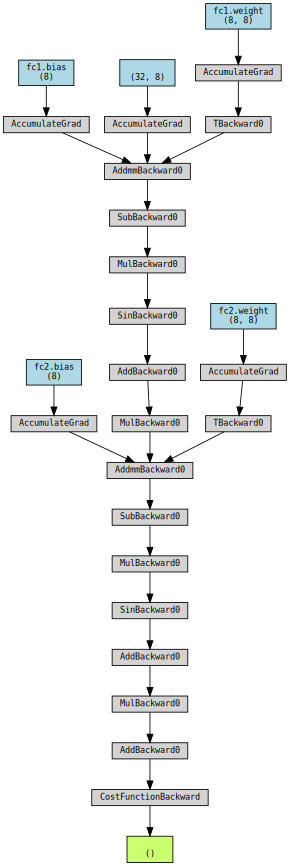

In [13]:
#print(f'input = {my_input}')
output = model(my_input)
print(f'Output = {output}')

param_dict = dict(model.named_parameters())
print(param_dict)  # Debugging: print the parameters to ensure they are correct
make_dot(output, params=param_dict)

In [14]:
target = torch.tensor(0.0, requires_grad=True)
criterion = nn.L1Loss()
#criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), momentum=MOMENTUM, lr=LR, weight_decay=WEIGHT_DECAY)

In [15]:
epoch_history = []
loss_history = []
for epoch in range(NUM_EPOCHS):
    epoch_history.append(epoch)
    #optimizer.zero_grad()
    model_output = model(my_input)
    loss = criterion(model_output, target)
    loss_history.append(float(loss))
    loss.backward()
    optimizer.step()
    
    if epoch % 50 == 0:
        print(f"Epoch {epoch}, Cost: {loss:.3f}")
        # Check gradients
        for name, param in model.named_parameters():
            if param.grad is not None:
                print(f'Epoch {epoch}, {name} grad: {param.grad.norm():.2f}')
            else:
                print(f'Epoch {epoch}, {name} grad is None')

    optimizer.zero_grad()


Epoch 0, Cost: 286.569
Epoch 0, fc1.weight grad: 2564.16
Epoch 0, fc1.bias grad: 1282.08
Epoch 0, fc2.weight grad: 3887.90
Epoch 0, fc2.bias grad: 1991.65
Epoch 50, Cost: 328.709
Epoch 50, fc1.weight grad: 24347.82
Epoch 50, fc1.bias grad: 12173.91
Epoch 50, fc2.weight grad: 3448.56
Epoch 50, fc2.bias grad: 1990.08
Epoch 100, Cost: 351.441
Epoch 100, fc1.weight grad: 25488.76
Epoch 100, fc1.bias grad: 12744.38
Epoch 100, fc2.weight grad: 2848.07
Epoch 100, fc2.bias grad: 1536.39


Text(0, 0.5, 'Loss')

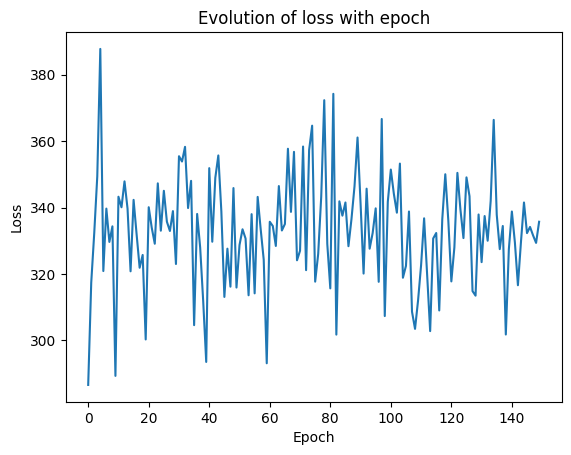

In [16]:
plt.plot(epoch_history, loss_history)
plt.title('Evolution of loss with epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')


In [17]:
for layer in model.children():
    if isinstance(layer, nn.Linear):
        print('weight:', layer.weight)
        print('bias:', layer.bias)

weight: Parameter containing:
tensor([[ 9.1815e-01, -9.6993e+00,  2.5427e-02, -9.6506e+00, -9.7189e+00,
         -9.6924e+00, -1.8829e-02, -5.6123e-02],
        [ 6.5581e-02,  8.0164e+01, -3.5676e-02,  7.9175e+01,  7.9112e+01,
          7.9179e+01,  2.0327e-02, -1.7168e-02],
        [-1.1084e-03, -2.1656e+01,  9.6240e-01, -2.1712e+01, -2.1616e+01,
         -2.1687e+01, -1.7780e-03, -4.8943e-02],
        [ 6.1197e-02,  1.0751e+02,  8.7102e-03,  1.0853e+02,  1.0750e+02,
          1.0759e+02,  2.9043e-02, -1.3849e-02],
        [-1.2088e-02,  5.0218e+01,  2.1199e-02,  5.0085e+01,  5.1083e+01,
          5.0071e+01,  5.2865e-03, -5.2621e-02],
        [ 1.1756e-02, -1.3245e+02,  3.1357e-02, -1.3258e+02, -1.3242e+02,
         -1.3141e+02, -2.1441e-02, -1.3204e-02],
        [-4.9973e-02,  7.6260e+00, -3.5976e-02,  7.5166e+00,  7.5058e+00,
          7.6070e+00,  1.0585e+00,  2.0174e-02],
        [-2.1472e-02, -3.6048e+01, -2.0082e-02, -3.6082e+01, -3.6116e+01,
         -3.6100e+01,  3.3216e-02, 